# Model Data Confrontation #1

In this tutorial, we demonstrate how to use `Pyleoclim` for spectral analysis of proxy records and model simulations, along with the visualization.

In the 1st part, as a presentation of the spectral analysis funtionalities, we reproduce the results in [Zhu et al. (2019)](https://www.pnas.org/content/early/2019/04/09/1809959116).

In the 2nd part, as a practice, the readers should play with the functionalities, with the help of the [documentation](https://pyleoclim-util.readthedocs.io/en/latest/core/ui.html#), and compare the results from different spectral analysis methods.

In [1]:
# load essential packages
%load_ext autoreload
%autoreload 2
    
import os
import pickle

import numpy as np
import pandas as pd
from tqdm import tqdm

import pyleoclim as pyleo  # make an alias name for "pyleoclim"

## Part I: a presentation of the `Pyleoclim` spectral analysis functionalities

### Load GMST data

#### Load PMIP3 simulations

The PMIP3 simulations ([Braconnot et al. 2012](https://www.nature.com/articles/nclimate1456)) of global mean surface temperature (GMST) are stored in a text file and can be imported with `Pandas` conveniently.
The file includes several ensemble members for CESM and GISS simulations, for which we substitue with their ensemble mean series.

In [2]:
# load the raw data
df = pd.read_table('../data/PMIP3_GMST.txt')

# display the raw data
df

,Year,bcc_csm1_1,CCSM4,FGOALS_gl,FGOALS_s2,IPSL_CM5A_LR,MPI_ESM_P,CSIRO,GISS-E2-R_r1i1p121,GISS-E2-R_r1i1p127,...,CESM_member_1,CESM_member_2,CESM_member_3,CESM_member_4,CESM_member_5,CESM_member_6,CESM_member_7,CESM_member_8,CESM_member_9,CESM_member_10
0,850,-0.570693,-0.431830,NaN,-0.620995,-0.475963,-0.170230,NaN,0.116333,0.155407,...,0.036672,0.067692,0.085340,-0.000616,0.157021,0.048458,0.038173,-0.027151,0.143404,-0.053464
1,851,-0.698903,-0.411177,NaN,-0.753160,-0.742970,-0.303124,-0.398695,0.068174,0.210337,...,0.246816,0.181400,0.251417,0.170710,0.165139,0.324856,0.191677,0.120951,0.216921,0.068698
2,852,-0.575440,-0.404802,NaN,-0.743508,-0.758939,-0.422623,-0.406343,0.060088,0.240585,...,0.187429,0.065922,0.190229,0.264551,0.092629,0.386593,0.068904,0.292246,0.101564,0.200259
3,853,-0.724757,-0.552719,NaN,-0.869331,-0.746460,-0.335177,-0.353557,-0.074396,0.030596,...,0.202443,0.089054,-0.031298,0.205805,0.049447,0.023312,-0.041356,0.206064,0.212954,0.288272
4,854,-0.724328,-0.734938,NaN,-0.826238,-0.684093,-0.650792,-0.416140,-0.402800,-0.330589,...,0.062795,0.137882,-0.233049,-0.227240,-0.156577,-0.339176,-0.103825,0.058420,-0.006102,-0.006619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1161,2011,1.013544,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1162,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1163,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1164,2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# create a new pandas.DataFrame to store the processed data
df_new = df.copy()

# remove the data columns for CESM and GISS ensemble members
for i in range(10):
    df_new = df_new.drop([f'CESM_member_{i+1}'], axis=1)
    
df_new = df_new.drop(['GISS-E2-R_r1i1p127.1'], axis=1)
df_new = df_new.drop(['GISS-E2-R_r1i1p127'], axis=1)
df_new = df_new.drop(['GISS-E2-R_r1i1p121'], axis=1)

# calculate the ensemble mean for CESM and GISS, and add the results into the table
df_new['CESM'] = df[[
    'CESM_member_1',
    'CESM_member_2',
    'CESM_member_3',
    'CESM_member_4',
    'CESM_member_5',
    'CESM_member_6',
    'CESM_member_7',
    'CESM_member_8',
    'CESM_member_9',
    'CESM_member_10',
]].mean(axis=1)

df_new['GISS'] = df[[
    'GISS-E2-R_r1i1p127.1',   
    'GISS-E2-R_r1i1p127',
    'GISS-E2-R_r1i1p121',
]].mean(axis=1)

# display the processed data
df_new

,Year,bcc_csm1_1,CCSM4,FGOALS_gl,FGOALS_s2,IPSL_CM5A_LR,MPI_ESM_P,CSIRO,HadCM3,CESM,GISS
0,850,-0.570693,-0.431830,NaN,-0.620995,-0.475963,-0.170230,NaN,-0.620517,0.049553,0.127429
1,851,-0.698903,-0.411177,NaN,-0.753160,-0.742970,-0.303124,-0.398695,-0.553043,0.193858,0.138796
2,852,-0.575440,-0.404802,NaN,-0.743508,-0.758939,-0.422623,-0.406343,-0.560791,0.185033,0.098170
3,853,-0.724757,-0.552719,NaN,-0.869331,-0.746460,-0.335177,-0.353557,-0.438949,0.120470,-0.054552
4,854,-0.724328,-0.734938,NaN,-0.826238,-0.684093,-0.650792,-0.416140,-0.812194,-0.081349,-0.407169
...,...,...,...,...,...,...,...,...,...,...,...
1161,2011,1.013544,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1162,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1163,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1164,2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now we define `pyleoclim.Series` for each simulated GMST time series.
A `pyleoclim.Series` represents a time series object that comes with a collection of methods, such as performing spectral analysis, wavelet analysis, interpolation, plotting, and so on.
More details are documented in [the documentation website](https://pyleoclim-util.readthedocs.io/en/stable/core/ui.html#series-pyleoclim-series).

In [4]:
# store each pyleoclim.Series() object into a dictionary
ts_dict = {}
for name in df_new.columns[1:]:
    ts_dict[name] = pyleo.Series(
        time=df_new['Year'].values,  # the time axis
        value=df_new[name].values,   # the value axis
        label=name,                  # optional metadata: the nickname of the series
        time_name='Time',            # optional metadata: the name of the time axis
        time_unit='yrs',             # optional metadata: the unit of the time axis
        value_name='GMST anom.',     # optional metadata: the name of the value axis
        value_unit='K',              # optional metadata: the unit of the value axis
    )

Once a `pyleoclim.Series` is defined, we can easily visualize it by calling the `pyleoclim.Series.plot()` method.
For instance, we plot the CCSM4 GMST below:

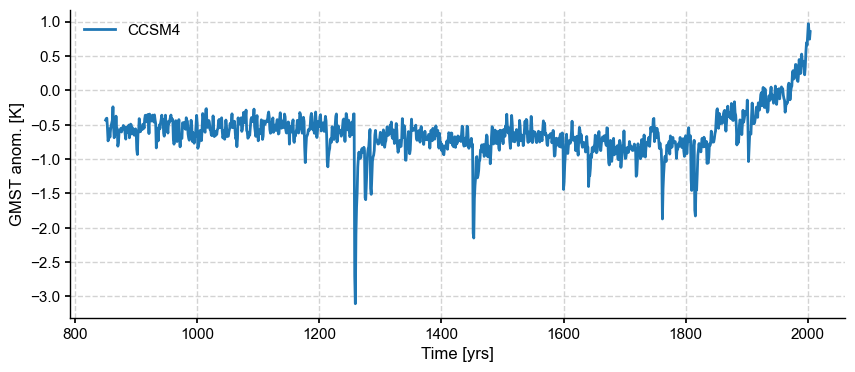

In [5]:
fig, ax = ts_dict['CCSM4'].plot()

Note that the return of the `plot()` method is a list of a `matplotlib.pyplot.figure` and a `matplotlib.pyplot.axis`.
That means all possible `matplotlib` manipulations can follow.
For instance, let's change the limit of the y-axis and the label below.

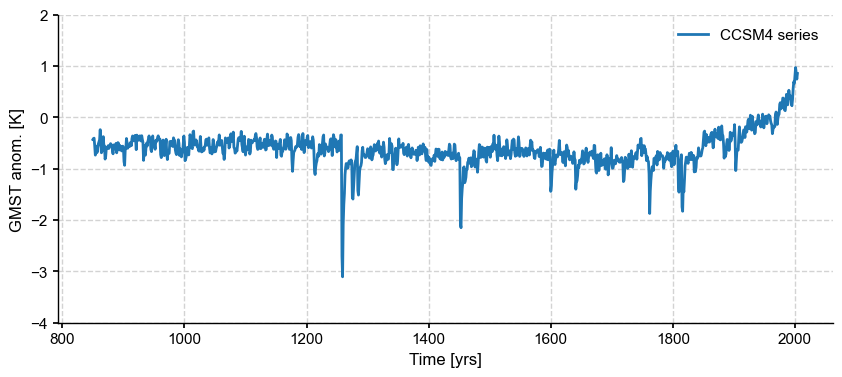

In [6]:
fig, ax = ts_dict['CCSM4'].plot(mute=True, label='CCSM4 series')  # the argument "mute=True" means to hold the display
ax.set_ylim([-4, 2])
pyleo.showfig(fig)  # display the final presentation of the figure

Note that when we want to modify on the original `fig` and `ax` returned from `pyleoclim.Series.plot()`, we need to use the `mute=True` argument to first hold the display of the figure, and then use `pyleoclim.showfig(fig)` to display the final presentation of the figure.

With the same mechanism, we may plot two time series in the same figure as following, in which we use the argument `ax=ax` to specify that the we'd like to plot the series of GISS into the same `matplotlib.pyplot.axis`.

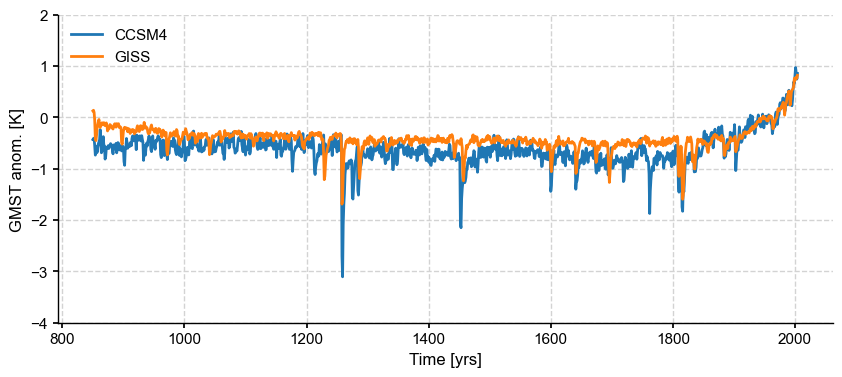

In [7]:
fig, ax = ts_dict['CCSM4'].plot(mute=True)
ts_dict['GISS'].plot(ax=ax)  # the argument "ax=ax" indicates we'd like to plot into the "ax" we get from the previous line of code 
ax.set_ylim([-4, 2])
pyleo.showfig(fig)

Is there a way to plot a collection of time series at once? Absolutely.
We can define a `pyleoclim.MultipleSeries` object, which takes a list of `pyleoclim.Series` objects as input.

Since we have defind a dictionary of a collection of `pyleoclim.Series` objects, we may first convert this dictionary into a list, and then use that list to define a `pyleoclim.MultipleSeries` object.

In [8]:
ts_list = [v for k, v in ts_dict.items()]  # a pythonic way to convert the pyleo.Series items in the dictionary to a list
ms_pmip = pyleo.MultipleSeries(ts_list)

Now that the `pyleoclim.MultipleSeries` called "ms_pmip" is defined, we can visualize all the time series at once by calling the `pyleoclim.MultipleSeries.plot()` method.

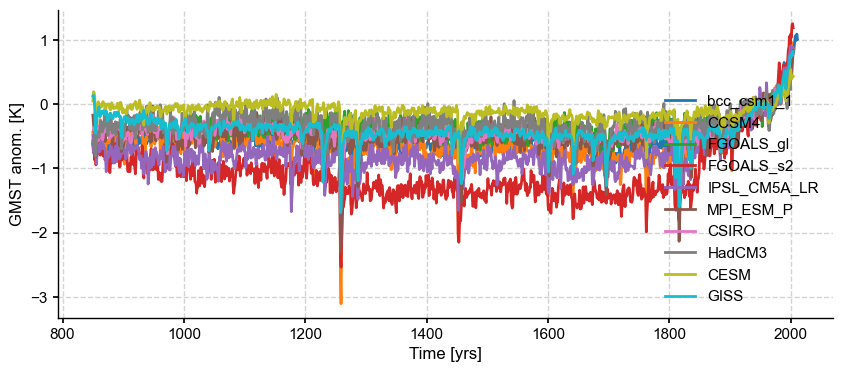

In [9]:
fig, ax = ms_pmip.plot()

You may notice that the legend is not in its best place, and we may want to move it to the right side.
We can achieve that by passing a dictionary of arguments for `matplotlib.pyplot.axis.legend()` (see the [matplotlib documentation](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.legend.html) for details) as below:

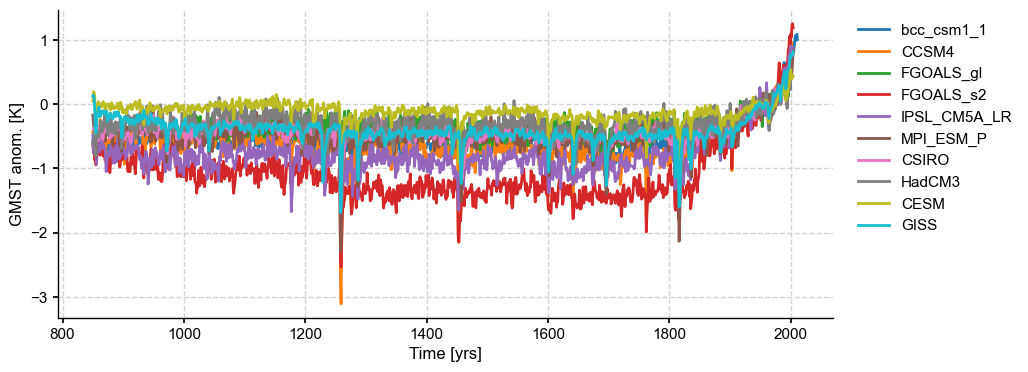

In [10]:
fig, ax = ms_pmip.plot(
    lgd_kwargs={
        'loc': 'upper right',         # put the legend anchor to the upper right corner
        'bbox_to_anchor': (1.25, 1),  # move the legend to the right side
    }
)

Now that the loading of PMIP3 simulations is complete, let's move on to proxies, LMR ([Hakim et al. 2016](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016JD024751), [Tardif et al. 2019](https://cp.copernicus.org/articles/15/1251/2019/)), and deglacial simulations.

#### Load proxies, LMR, and deglacial simulations

We've preprocessed the data for proxies, LMR, and deglacial simulations, and stored in a [Python pickle](https://docs.python.org/3/library/pickle.html) file, which includes two dictionaries called `ts` and `vs`.
`ts` includes the time axis for each dataset,
and `vs` includes the value axis for each dataset.

We load the pickle file below and print out the dictionary keys to see how many datasets we have.

In [11]:
with open('../data/PNAS19_data.pkl', 'rb') as f:
    ts, vs = pickle.load(f)
    
print(vs.keys())

dict_keys(['EDC', 'HadCRUT4', 'GAST', 'ProbStack', 'LMR', 'trace21ka_full', 'trace21ka_mwf', 'trace21ka_orb', 'trace21ka_ghg', 'trace21ka_ice', 'DGns', 'SIM2bl'])


Now we extract the data and organize them in the format of `pyleoclim.Series`.

In [12]:
for name in vs.keys():
    # we may specify specific metadata for each dataset with the if-clauses
    if name == 'LMR':
        value_name = 'GSMT anom.'
        value_unit = 'K'
    elif name in ['trace21ka_full', 'trace21ka_mwf', 'trace21ka_orb', 'trace21ka_ghg', 'trace21ka_ice', 'DGns', 'SIM2bl']:
        value_name = 'GSMT'
        value_unit = 'K'
    else:
        value_name = 'Proxy Value'
        value_unit = None
        
    if name == 'trace21ka_full':
        label = 'TraCE-21ka'
    else:
        label = name
        
    ts_dict[name] = pyleo.Series(
        time=ts[name],
        value=vs[name],
        label=label,
        time_name='Time',
        time_unit='yrs',
        value_name=value_name,
        value_unit=value_unit,
    )

Now we define `pyleoclim.MultipleSeries` for each group of datasets.

In [13]:
ms_obs = pyleo.MultipleSeries(
    [ts_dict[name] for name in ['EDC', 'HadCRUT4', 'GAST', 'ProbStack']]
)
ms_deglacial = pyleo.MultipleSeries(
    [ts_dict[name] for name in ['trace21ka_full', 'DGns', 'SIM2bl']]
)

Now we visualize what we have.
LMR first.

Note that here we use the median of the LMR ensembles for our analysis for simplicity and calculation speed, while all the ensemble members are being analyzed in the original paper, so the estimated scaling slope value that we show later would be a bit different from that in the original paper. 

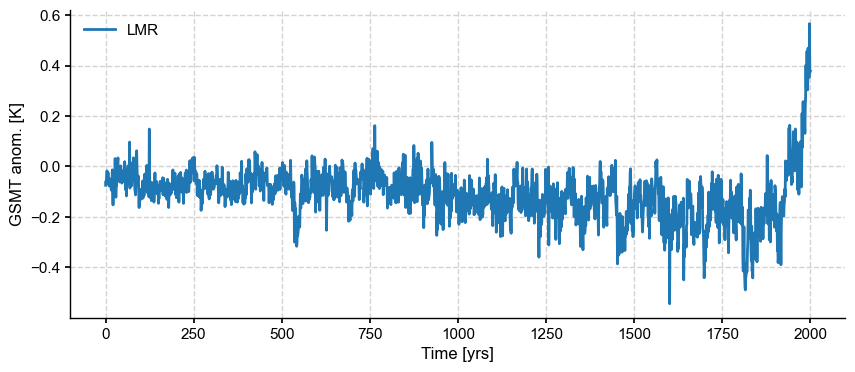

In [14]:
fig, ax = ts_dict['LMR'].plot()

Then the proxies.

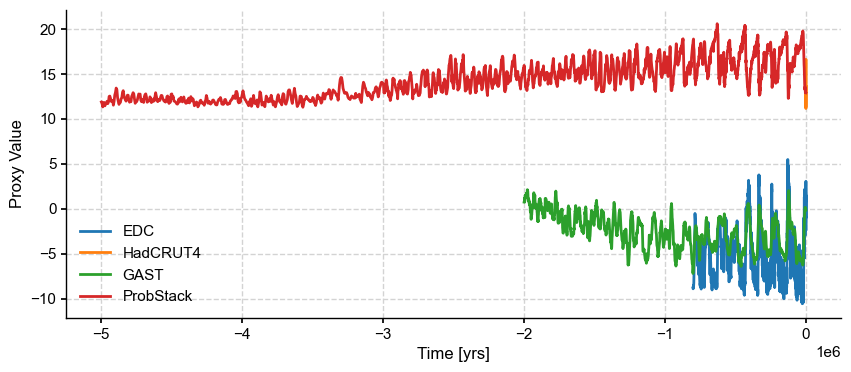

In [15]:
fig, ax = ms_obs.plot()

We notice that the time axis is in unit of years by default, which is odd for paleo-records prior to CE.
We can easily convert the time unit to "kyrs BP" by calling the `pyleoclim.MultipleSeries.convert_time_unit` method as below:

The time axis has been adjusted to be ascending!
The time axis has been adjusted to be ascending!
The time axis has been adjusted to be ascending!
The time axis has been adjusted to be ascending!


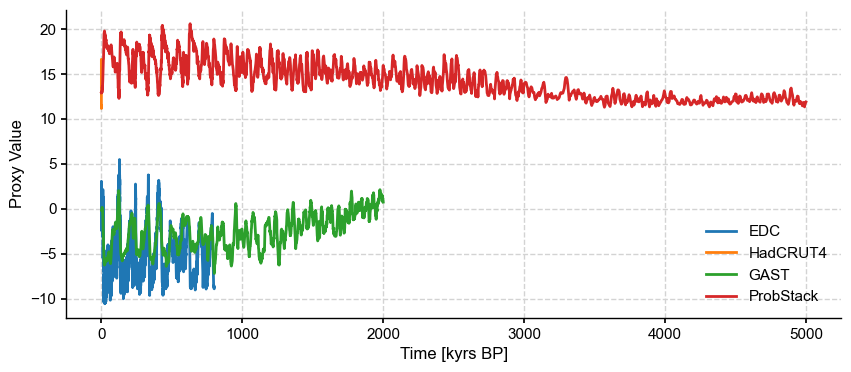

In [16]:
ms_obs = ms_obs.convert_time_unit('kyrs BP')
fig, ax = ms_obs.plot()

Okay, now the time unit is "kyrs BP", and the numerical time values are ascending.
What if we'd like to present the data in a way that the right hand side represents more recent time?
Well, we can manipulate the returned `matplotlib.pyplot.axis` object as mentioned earlier, or just use the `invert_xais=True` argument of the `pyleoclim.MultipleSeries.plot()` method as below:

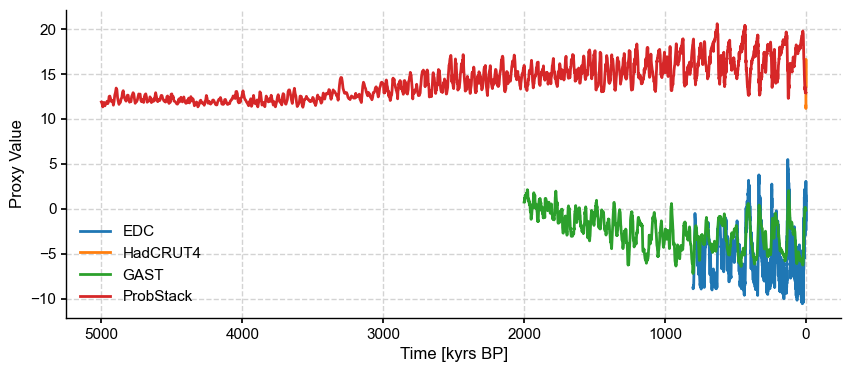

In [17]:
fig, ax = ms_obs.plot(invert_xaxis=True)

Similarly, we convert the time unit of deglacial simulations to "kyrs BP" and then visualize them with the x-axis inverted and the lelgend location moved to the right side.

The time axis has been adjusted to be ascending!
The time axis has been adjusted to be ascending!
The time axis has been adjusted to be ascending!


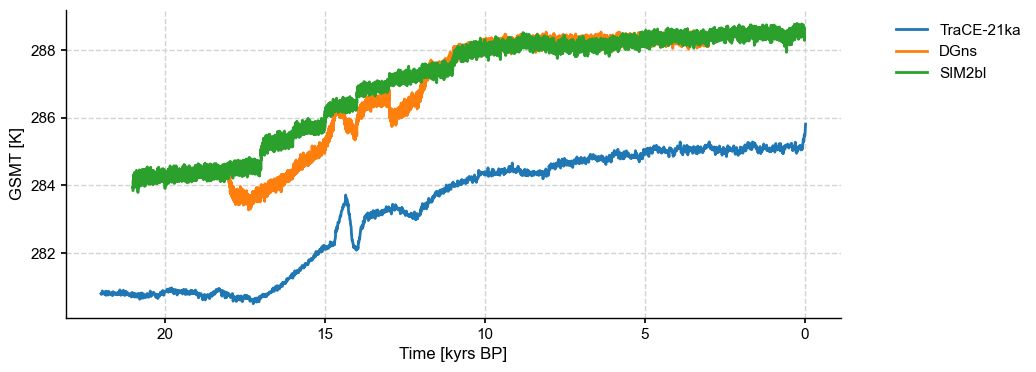

In [18]:
ms_deglacial = ms_deglacial.convert_time_unit('kyrs BP')
fig, ax = ms_deglacial.plot(
    lgd_kwargs={
        'loc': 'upper right',         # put the legend anchor to the upper right corner
        'bbox_to_anchor': (1.25, 1),  # move the legend to the right side
    },
    invert_xaxis=True,
)

Now that all data needed has been loaded, let's perform spectral analysis using the Weighted Wavelet Z-transform method (WWZ)([Foster 1996](https://ui.adsabs.harvard.edu/abs/1996AJ....112.1709F), [Kirchner & Neal 2013](https://www.pnas.org/content/110/30/12213)), which can handle unevenly-spaced data without interpolation.

### Spectral analysis using WWZ

We may perform spectral analysis on time series by calling the `pyleoclim.Series.spectral()` method.
It has the argument `method` to specify which method to use. It is set to `wwz` by default to use the WWZ method. 
It also has an argument `freq_method` to specify the approach to generate the frequency vector for the analysis.
It is set to `log` by default to use generate the frequency vector in a log space.
Here, we set to `nfft` so that we can reproduce the result in the original paper [Zhu et al. (2019)](https://www.pnas.org/content/early/2019/04/09/1809959116).
Other arguments specific to each spectral analysis method can be passed in through the argument `settings`.
Since WWZ is originally a wavelet analysis method, we may specify `tau` to specify the evenly-spaced time points (the temporal resolution) for wavelet analysis.
However, since our purpose here is spectral analysis, the temporal resolution is not required to be high, and we may use small values to accelerate the calculation.
Please see the documentation on [pyleoclim.Series.spectral](https://pyleoclim-util.readthedocs.io/en/stable/core/Series/spectral.html#pyleoclim.core.ui.Series.spectral) and the [wwz_psd](https://pyleoclim-util.readthedocs.io/en/stable/utils/spectral/wwz_psd.html?highlight=wwz_psd) function that `pyeloclim.Series.spectral` called for details.

The method will return a [pyleoclim.PSD](https://pyleoclim-util.readthedocs.io/en/stable/core/ui.html#psd-pyleoclim-psd) object, which includes the estimated power spectral density (PSD) along with the information of the frequency axis, and the object iteself is intended for lalter operations such as visualization, scaling slope estimation, and significance test.

In [39]:
%%time

# we will store the result in a dictionary with the dataset names as keys
psd_wwz = {}
for name, ts in ts_dict.items():
    print(f'Processing {name} ...')
    print(f'Data length: {np.size(ts.time)}')
    if name in ['DGns', 'SIM2bl']:
        ntau = 51  # to accelerate the calculation; the smaller, the faster
    else:
        ntau = 501
    tau = np.linspace(np.min(ts.time), np.max(ts.time), ntau)
    psd_wwz[name] = ts.spectral(method='wwz', freq_method='nfft', settings={'tau': tau})

Processing bcc_csm1_1 ...
Data length: 1162
Processing CCSM4 ...
Data length: 1155
Processing FGOALS_gl ...
Data length: 999
Processing FGOALS_s2 ...
Data length: 1155
Processing IPSL_CM5A_LR ...
Data length: 1155
Processing MPI_ESM_P ...
Data length: 1155
Processing CSIRO ...
Data length: 1150
Processing HadCM3 ...
Data length: 1151
Processing CESM ...
Data length: 1155
Processing GISS ...
Data length: 1155
Processing EDC ...
Data length: 5785
Processing HadCRUT4 ...
Data length: 2015
Processing GAST ...
Data length: 2000
Processing ProbStack ...
Data length: 2051
Processing LMR ...
Data length: 2001
Processing trace21ka_full ...
Data length: 2204
Processing trace21ka_mwf ...
Data length: 1904
Processing trace21ka_orb ...
Data length: 2204
Processing trace21ka_ghg ...
Data length: 2204
Processing trace21ka_ice ...
Data length: 1904
Processing DGns ...
Data length: 15000
Processing SIM2bl ...
Data length: 21000
CPU times: user 59min 33s, sys: 9.37 s, total: 59min 42s
Wall time: 5min 27

The calculation takes a while, and we may store the result to a pickle file for quick loading in the future.

In [32]:
with open('./data/PNAS19_psd.pkl', 'wb') as f:
    pickle.dump(psd_wwz, f)

### Visualization the PSD objects returned from the spectral analysis

Now let's visualize the results.
In below cells, we first define a colormap, then specify the colors for each `pyleoclim.PSD` object.
Similar to `pyleoclim.MultipleSeries`, we may also define a `pyleoclim.MultiplePSD` object for a collection of the `pyleoclim.PSD` objects for operations at once.

In [21]:
# quick loading of the pyleoclim.PSD objects
with open('../data/PNAS19_psd.pkl', 'rb') as f:
    psd_wwz = pickle.load(f)

In [22]:
# define the tableau20 colors
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.) 

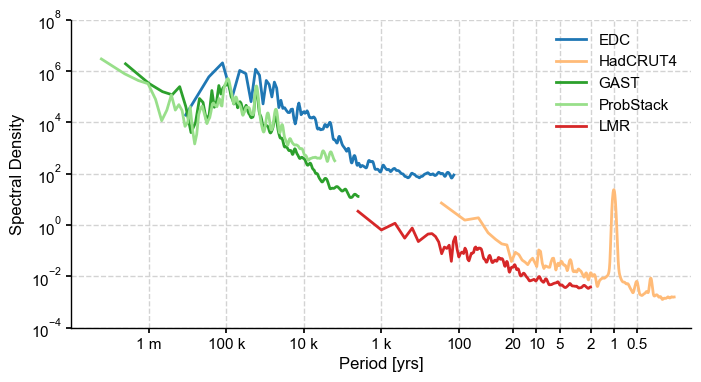

In [23]:
# define a dictionary for the colors
clr_dict = {
    'EDC': tableau20[0],
    'HadCRUT4': tableau20[3],
    'GAST': tableau20[4],
    'ProbStack': tableau20[5],
    'LMR': tableau20[6],
}

# specify color for each pyleoclim.PSD objects
for k, v in clr_dict.items():
    psd_wwz[k].plot_kwargs = {'color': v}
    
# for the period axis customization later
period_ticks = [0.5, 1, 2, 5, 10, 20, 100, 1e3, 1e4, 1e5, 1e6]
period_ticklabels = ['0.5', '1', '2', '5', '10', '20', '100', '1 k', '10 k', '100 k', '1 m']

# define the pyleoclim.MultiplePSD object and visualize the several pyleoclim.PSD objects at once
mpsd_obs = pyleo.MultiplePSD([psd_wwz[name] for name in ['EDC', 'HadCRUT4', 'GAST', 'ProbStack', 'LMR']])
fig, ax = mpsd_obs.plot(figsize=[8, 4], mute=True)
ax.set_xlim([1e7, 0.1])
ax.set_ylim([1e-4, 1e8])
ax.set_xticks(period_ticks)
ax.set_xticklabels(period_ticklabels)
ax.set_ylabel('Spectral Density')
pyleo.showfig(fig)

We have reproduced Fig. 1 of the original paper above.

To reproduce the upper panel of Fig. 2, we reset the colors for observations to be grey, and set the opacity via `alpha`, as well as the line width via `linewidth` below.
Note that the colors for the PMIP3 simulations will follow a default list of Python.

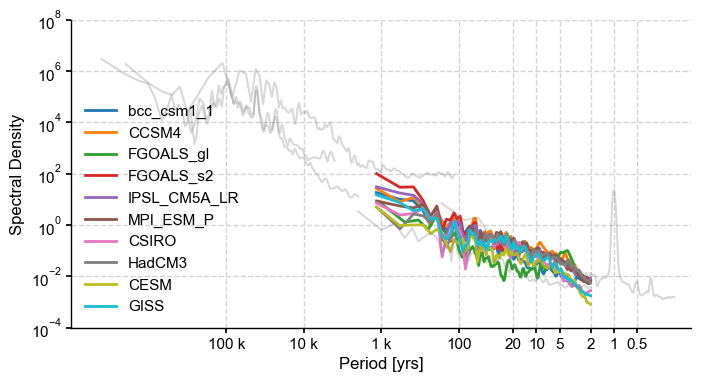

In [24]:
clr_dict = {
    'EDC': 'grey',
    'HadCRUT4': 'grey',
    'GAST': 'grey',
    'ProbStack': 'grey',
    'LMR': 'grey'
}
for k, v in clr_dict.items():
    psd_wwz[k].plot_kwargs = {'color': v, 'alpha': 0.3, 'linewidth': 1.5}
    
mpsd_obs = pyleo.MultiplePSD([psd_wwz[name] for name in ['EDC', 'HadCRUT4', 'GAST', 'ProbStack', 'LMR']])

period_ticks = [0.5, 1, 2, 5, 10, 20, 100, 1000, 10000, 100000]
period_ticklabels = ['0.5', '1', '2', '5', '10', '20', '100', '1 k', '10 k', '100 k']

pmip_names = ['bcc_csm1_1', 'CCSM4', 'FGOALS_gl', 'FGOALS_s2', 'IPSL_CM5A_LR', 'MPI_ESM_P', 'CSIRO', 'HadCM3', 'CESM', 'GISS']
mpsd_pmip = pyleo.MultiplePSD([psd_wwz[name] for name in pmip_names])
fig, ax = mpsd_pmip.plot(figsize=[8, 4], mute=True)
mpsd_obs.plot(ax=ax, legend=False)
ax.set_xlim([1e7, 0.1])
ax.set_ylim([1e-4, 1e8])
ax.set_xticks(period_ticks)
ax.set_xticklabels(period_ticklabels)
ax.set_ylabel('Spectral Density')
pyleo.showfig(fig)

Similarly, we reproduce the lower panel of Fig. 2 of the original paper as below:

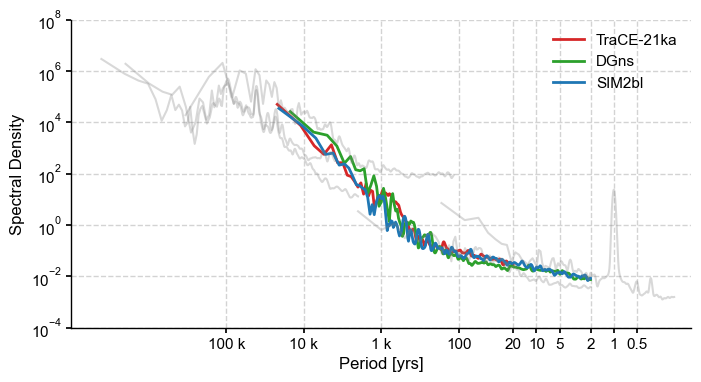

In [25]:
clr_deglacial_dict = {
    'trace21ka_full': tableau20[6],
    'DGns': tableau20[4],
    'SIM2bl': tableau20[0],
}
for k, v in clr_deglacial_dict.items():
    psd_wwz[k].plot_kwargs = {'color': v}


period_ticks = [0.5, 1, 2, 5, 10, 20, 100, 1000, 10000, 100000]
period_ticklabels = ['0.5', '1', '2', '5', '10', '20', '100', '1 k', '10 k', '100 k']

mpsd_deglacial = pyleo.MultiplePSD([psd_wwz[name] for name in ['trace21ka_full', 'DGns', 'SIM2bl']])
fig, ax = mpsd_deglacial.plot(figsize=[8, 4], mute=True)
mpsd_obs.plot(ax=ax, legend=False)
ax.set_xlim([1e7, 0.1])
ax.set_ylim([1e-4, 1e8])
ax.set_xticks(period_ticks)
ax.set_xticklabels(period_ticklabels)
ax.set_ylabel('Spectral Density')
pyleo.showfig(fig)

### Estimation of the scaling exponents

You may notice that something is missing comparing our reproduced figures to the figures in the original paper -- the scaling exponents.

Below, we use the `pyleoclim.PSD.beta_est()` method to estimate the scaling exponents for each dataset.
To do that, we need to specify the frequency range over which we estimate.
The estimation is achieved utilizing linear regression in the log-log space.
Since the frequency vector we used is `nfft`, which is defined in a linear space, so the frequency points will be denses over the high frequency band and coarser over the low frequency band, and binning is needed prior to the linear regression, so there's an argument called `logf_binning_step` that we need to set.
While the default is `max`, which means to use the largest spacing for binning, here we use the first spacing of the frequency vector, as per the original paper.

Note that we estimate exponents over two scaling regimes with a break at 400 yrs for the deglacial simualtions.

In [26]:
# define frequency range for the exponent estimation
franges = {
    'EDC': [1/50000, 1/1500],
    'HadCRUT4': [1/50, 6],
    'GAST': [1/100000, 1/2000],
    'ProbStack': [1/100000, 1/10000],
    'LMR': [1/1000, 1/2],
}

# for PMIP simulations, we estimation the scaling slope over 2-500 yrs
for name in pmip_names:
    franges[name] = [1/500, 1/2]

beta_est_res = {}
for name, frange in franges.items():
    beta_est_res[name] = psd_wwz[name].beta_est(fmin=frange[0], fmax=frange[-1], logf_binning_step='first')
    
# for deglacial model simulations, we have two scaling regimes, one over 20-400 yrs, and another over 400-2000 yrs
s_break = 400
franges_s = {
    'trace21ka_full': [1/s_break, 1/21],  # note that for TraCE-21ka, the slope is estimated over 21-400 yrs due to its temporal resolution 
    'DGns': [1/s_break, 1/20],
    'SIM2bl': [1/s_break, 1/20],
}
franges_l = {
    'trace21ka_full': [1/2000, 1/s_break],
    'DGns': [1/2000, 1/s_break],
    'SIM2bl': [1/2000, 1/s_break],
}

beta_est_s_res = {}
for name, frange in franges_s.items():
    beta_est_s_res[name] = psd_wwz[name].beta_est(fmin=frange[0], fmax=frange[-1], logf_binning_step='first')
    
beta_est_l_res = {}
for name, frange in franges_l.items():
    beta_est_l_res[name] = psd_wwz[name].beta_est(fmin=frange[0], fmax=frange[-1], logf_binning_step='first')

Now we re-plot the figures with the estimated scaling exponents displayed in the legend and visualized via straight lines in the figure.
Below is for Fig. 1.

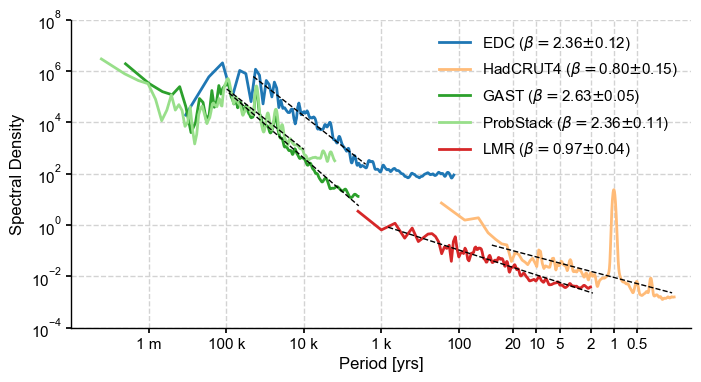

In [27]:
clr_dict = {
    'EDC': tableau20[0],
    'HadCRUT4': tableau20[3],
    'GAST': tableau20[4],
    'ProbStack': tableau20[5],
    'LMR': tableau20[6],
}

for k, v in clr_dict.items():
    psd_wwz[k].plot_kwargs = {'color': v}
    
period_ticks = [0.5, 1, 2, 5, 10, 20, 100, 1e3, 1e4, 1e5, 1e6]
period_ticklabels = ['0.5', '1', '2', '5', '10', '20', '100', '1 k', '10 k', '100 k', '1 m']

mpsd_obs = pyleo.MultiplePSD([psd_wwz[name] for name in ['EDC', 'HadCRUT4', 'GAST', 'ProbStack', 'LMR']])
fig, ax = mpsd_obs.plot(figsize=[8, 4], mute=True)
ax.set_xlim([1e7, 0.1])
ax.set_ylim([1e-4, 1e8])
ax.set_xticks(period_ticks)
ax.set_xticklabels(period_ticklabels)

labels = ax.get_legend_handles_labels()[-1]
new_labels = []
i = 0
for name in ['EDC', 'HadCRUT4', 'GAST', 'ProbStack', 'LMR']:
    res = beta_est_res[name]
    ax.plot(1/res['f_binned'], res['Y_reg'], linestyle='--', color='k', linewidth=1, zorder=99)
    new_labels.append(fr'{labels[i]} ($\beta=${res["beta"]:.2f}$\pm${res["std_err"]:.2f})')
    i += 1

ax.legend(labels=new_labels)
ax.set_ylabel('Spectral Density')
pyleo.showfig(fig)

Then the upper panel of Fig. 2.

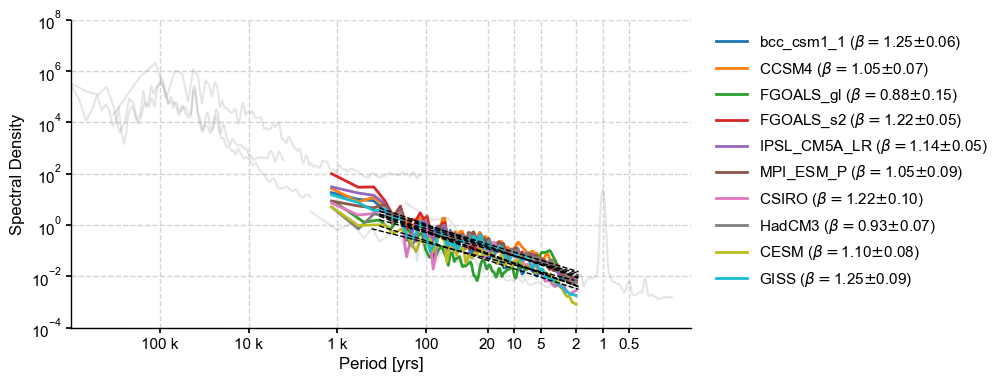

In [28]:
clr_dict = {
    'EDC': 'grey',
    'HadCRUT4': 'grey',
    'GAST': 'grey',
    'ProbStack': 'grey',
    'LMR': 'grey'
}
for k, v in clr_dict.items():
    psd_wwz[k].plot_kwargs = {'color': v, 'alpha': 0.2, 'linewidth': 1.5}
    
mpsd_obs = pyleo.MultiplePSD([psd_wwz[name] for name in ['EDC', 'HadCRUT4', 'GAST', 'ProbStack', 'LMR']])


period_ticks = [0.5, 1, 2, 5, 10, 20, 100, 1e3, 1e4, 1e5]
period_ticklabels = ['0.5', '1', '2', '5', '10', '20', '100', '1 k', '10 k', '100 k']

fig, ax = mpsd_pmip.plot(figsize=[8, 4], mute=True)

mpsd_obs.plot(ax=ax, legend=False)
ax.set_xlim([1e6, 0.1])
ax.set_ylim([1e-4, 1e8])
ax.set_xticks(period_ticks)
ax.set_xticklabels(period_ticklabels)

labels = ax.get_legend_handles_labels()[-1]
new_labels = []
i = 0
for name in pmip_names:
    res = beta_est_res[name]
    ax.plot(1/res['f_binned'], res['Y_reg'], linestyle='--', color='k', linewidth=1, zorder=99)
    new_labels.append(fr'{labels[i]} ($\beta=${res["beta"]:.2f}$\pm${res["std_err"]:.2f})')
    i += 1

ax.legend(labels=new_labels, loc='upper right', bbox_to_anchor=(1.5, 1))
ax.set_ylabel('Spectral Density')
pyleo.showfig(fig)

... and the lower panel of Fig. 2.

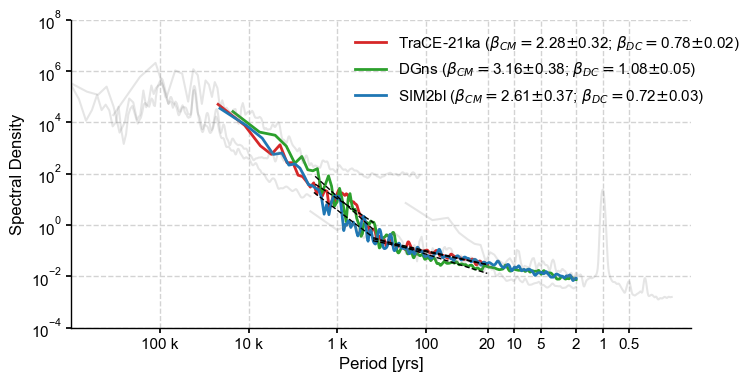

In [29]:
clr_dict = {
    'EDC': 'grey',
    'HadCRUT4': 'grey',
    'GAST': 'grey',
    'ProbStack': 'grey',
    'LMR': 'grey'
}
for k, v in clr_dict.items():
    psd_wwz[k].plot_kwargs = {'color': v, 'alpha': 0.2, 'linewidth': 1.5}
    
mpsd_obs = pyleo.MultiplePSD([psd_wwz[name] for name in ['EDC', 'HadCRUT4', 'GAST', 'ProbStack', 'LMR']])

clr_deglacial_dict = {
    'trace21ka_full': tableau20[6],
    'DGns': tableau20[4],
    'SIM2bl': tableau20[0],
}
for k, v in clr_deglacial_dict.items():
    psd_wwz[k].plot_kwargs = {'color': v}

period_ticks = [0.5, 1, 2, 5, 10, 20, 100, 1e3, 1e4, 1e5]
period_ticklabels = ['0.5', '1', '2', '5', '10', '20', '100', '1 k', '10 k', '100 k']

fig, ax = mpsd_deglacial.plot(figsize=[8, 4], mute=True)
mpsd_obs.plot(ax=ax, legend=False)
ax.set_xlim([1e6, 0.1])
ax.set_ylim([1e-4, 1e8])
ax.set_xticks(period_ticks)
ax.set_xticklabels(period_ticklabels)

labels = ax.get_legend_handles_labels()[-1]
new_labels = []
i = 0
for name in ['trace21ka_full', 'DGns', 'SIM2bl']:
    res_s = beta_est_s_res[name]
    res_l = beta_est_l_res[name]
    ax.plot(1/res_s['f_binned'], res_s['Y_reg'], linestyle='--', color='k', linewidth=1, zorder=99)
    ax.plot(1/res_l['f_binned'], res_l['Y_reg'], linestyle='--', color='k', linewidth=1, zorder=99)
    beta_s_str = r'$\beta_{DC}$'
    beta_s = res_s['beta']
    err_s = res_s['std_err']
    beta_l_str = r'$\beta_{CM}$'
    beta_l = res_l['beta']
    err_l = res_l['std_err']
    new_labels.append(fr'{labels[i]} ({beta_l_str}$=${beta_l:.2f}$\pm${err_l:.2f}; {beta_s_str}$=${beta_s:.2f}$\pm${err_s:.2f})')
    i += 1

ax.legend(labels=new_labels, loc='upper right', bbox_to_anchor=(1.1, 1))
ax.set_ylabel('Spectral Density')
pyleo.showfig(fig)

## Part II: a practice of comparing results from different spectral analysis method

Now it's time for the readers to practice the functionalities `Pyleoclim` provides.

We have performed spectral analysis using the WWZ method above, yet `Pyleoclim` provides also the classic multi-taper method (MTM, [Thomson 1982](Spectrum estimation and harmonic analysis. P)) and Lomb-Scargle periodogram ([Lomb 1976](https://link.springer.com/article/10.1007%2FBF00648343), [Scargle 1982](https://link.springer.com/article/10.1007%2FBF00648343)).
The MTM method can handle only evenly-spaced data, so for paleo-records, we need to first perform an interpolation prior to the spectral analysis.
The Lomb-Scargle peridogram, on the other hand, can handle unevenly-spaced data without interpolation.

For our practice, we'd like to perform spectral analysis on an unevenly-spaced time series using all the three methods and compare the results:
1. [WWZ](https://pyleoclim-util.readthedocs.io/en/stable/utils/spectral/wwz_psd.html?highlight=wwz_psd), or `pyleoclim.Series.spectral(method='wwz')` with appropriate arguments
2. [interpolation](https://pyleoclim-util.readthedocs.io/en/stable/core/Series/interp.html#pyleoclim.core.ui.Series.interp) + [MTM](https://pyleoclim-util.readthedocs.io/en/stable/utils/spectral/mtm.html?highlight=mtm), or `pyleoclim.Series.interp()` + `pyleoclim.Series.spectral(method='mtm')` with appropriate arguments
3. [Lomb-Scargle](https://pyleoclim-util.readthedocs.io/en/stable/utils/spectral/lombscargle.html?highlight=lomb%20scargle#pyleoclim.utils.spectral.lomb_scargle), or `pyleoclim.Series.spectral(method='lomb_scargle')` with appropriate arguments


### Details of the problem

Please complete the following steps:

1. Perform spectral analysis on the EDC dataset using WWZ, MTM, and Lomb-Scargle, and get three `pyleoclim.PSD` objects.
2. Estimate the scaling exponent over the frequency band [1/50000, 1/1500].
3. Visualize the three `pyleoclim.PSD` objects along with the information of the scaling exponents (with text in the legend and straight lines in the figure).
4. Compare the results from three methods, and discuss what you find.

### Demo answer (will be hided to the readers)

In [30]:
psd_mtm = {}
psd_ls = {}
psd_ls['EDC'] = ts_dict['EDC'].spectral(method='lomb_scargle', settings={'n50': 1})
psd_ls['LMR'] = ts_dict['LMR'].spectral(method='lomb_scargle', settings={'n50': 1})
psd_mtm['LMR'] = ts_dict['LMR'].spectral(method='mtm')

In [31]:
# print(psd_wwz['EDC'].amplitude / psd_ls['EDC'].amplitude)

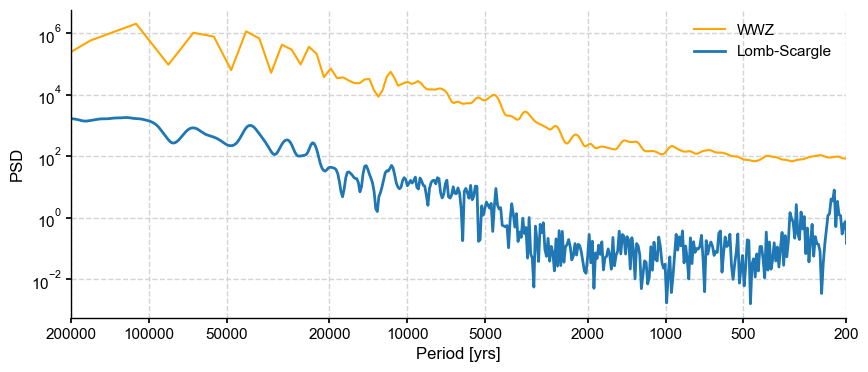

In [32]:
fig, ax = psd_wwz['EDC'].plot(mute=True, label='WWZ', color='orange', alpha=1)
psd_ls['EDC'].plot(ax=ax, label='Lomb-Scargle')
pyleo.showfig(fig)

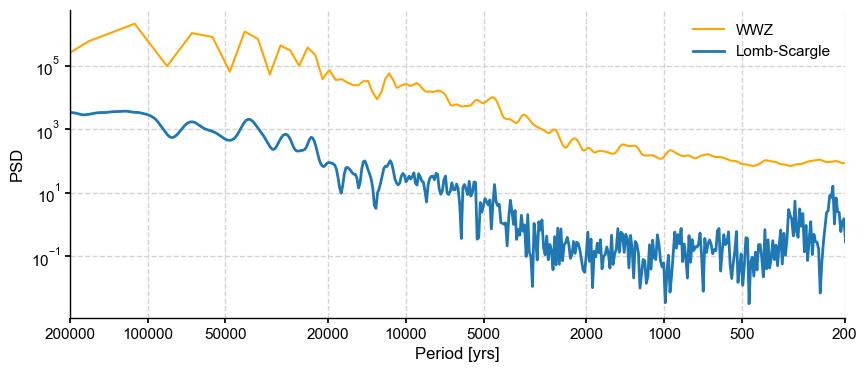

In [33]:
new_psd = psd_ls['EDC'].copy()
new_psd.amplitude = psd_ls['EDC'].amplitude*2

fig, ax = psd_wwz['EDC'].plot(mute=True, label='WWZ', color='orange', alpha=1)
new_psd.plot(ax=ax, label='Lomb-Scargle')
pyleo.showfig(fig)

In [34]:
def gen_noise(alpha, t, f0=None, m=None):
    ''' Generate a colored noise timeseries

    Args:
        alpha (float): exponent of the 1/f^alpha noise
        t (float): time vector of the generated noise
        f0 (float): fundamental frequency
        m (int): maximum number of the waves, which determines the highest frequency of the components in the synthetic noise

    Returns:
        y (array): the generated 1/f^alpha noise

    References:
        Eq. (15) in Kirchner, J. W. Aliasing in 1/f(alpha) noise spectra: origins, consequences, and remedies. Phys Rev E Stat Nonlin Soft Matter Phys 71, 066110 (2005).
    
    '''
    n = np.size(t)  # number of time points
    y = np.zeros(n)

    if f0 is None:
        f0 = 1/n  # fundamental frequency
    if m is None:
        m = n

    k = np.arange(m) + 1  # wave numbers

    theta = np.random.rand(int(m))*2*np.pi  # random phase
    for j in range(n):
        coeff = (k*f0)**(-alpha/2)
        sin_func = np.sin(2*np.pi*k*f0*t[j] + theta)
        y[j] = np.sum(coeff*sin_func)

    return y

from scipy import signal
np.random.seed(2333)

to_evenly = np.arange(1, 2001)
Xo_evenly = gen_noise(1, to_evenly, m=np.size(to_evenly)/2)  # set such m so that no aliasing occurs
ts_test = pyleo.Series(time=to_evenly, value=Xo_evenly)
psd_wwz_evenly = ts_test.spectral(method='wwz')

psd_ideal_ref_evenly = 0.5*psd_wwz_evenly.frequency**(-1)/(1/np.size(to_evenly))

psd_ls_evenly = signal.lombscargle(to_evenly, Xo_evenly, 2*np.pi*psd_wwz_evenly.frequency, normalize=False)
psd_ls_pyleo = ts_test.spectral(method='lomb_scargle')
psd_welch_evenly = ts_test.spectral(method='welch')

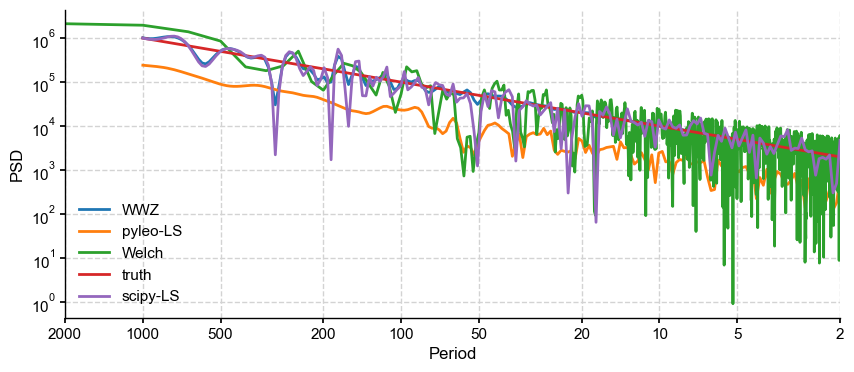

In [35]:
fig, ax = psd_wwz_evenly.plot(mute=True, label='WWZ')
psd_ls_pyleo.plot(ax=ax, label='pyleo-LS')
psd_welch_evenly.plot(ax=ax, label='Welch')
ax.plot(1/psd_wwz_evenly.frequency, psd_ideal_ref_evenly, label='truth')
ax.plot(1/psd_wwz_evenly.frequency, psd_ls_evenly*2, label='scipy-LS')
ax.legend()
pyleo.showfig(fig)

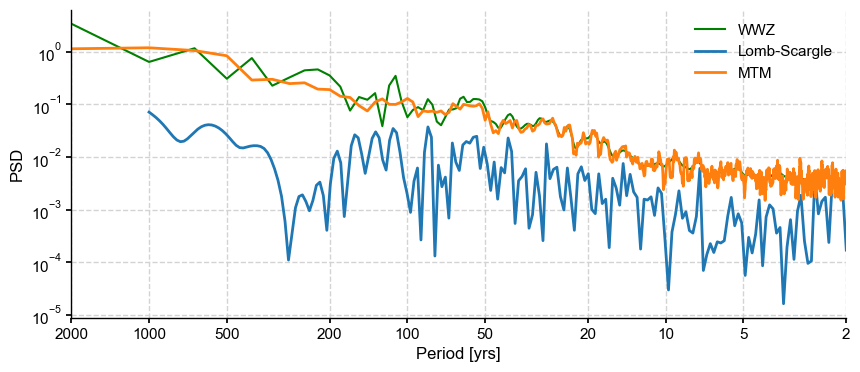

In [36]:
fig, ax = psd_wwz['LMR'].plot(mute=True, label='WWZ', color='green', alpha=1)
psd_ls['LMR'].plot(ax=ax, label='Lomb-Scargle')
psd_mtm['LMR'].plot(ax=ax, label='MTM')
pyleo.showfig(fig)

In [37]:
psd_mtm['EDC'] = ts_dict['EDC'].interp().spectral(method='mtm')

ValueError: A value in x_new is above the interpolation range.